# Imports
Needs both tf and torch since data is provided in tensorflow tensors
Uses Standard ML packages except torch_geometric (will need to install)

In [105]:
import os
import torch
import collections
import functools
import pickle
import tensorflow.compat.v1 as tf
import reading_utils
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import json
import numpy as np
import torch_geometric as pyg

print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 2.0.0+cpu with cuda None


# Importing Raw Data
Raw data is provided in tfrecord objects, need to open and parse it into a dictionary. Furthermore, the tensors need to be converted to torch tensors
Data is stored in parsed_data, which is a list of trajectories (1000 trajectories in train, 30 in valid, 30 in test)
## Structure of parsed_data:
`parsed_data[0]` is a dictionary of data associated w/ the first trajectory
`parsed_data[0]['position']` is a tensor of size (num_timesteps, num_particles, dimension) that holds the 2D or 3D position of each particle at each timestep. Data is given in 1000 timesteps, and in 2D, while the number of particles varies based on trajectory
`parsed_data[0]['particle_type']` is a tensor of size(num_particles) which gives the type of particle for each particle. This is trivial in the WaterDrop dataset since all particles are `type = 5`, which is water.
Other keys in the dictionary are not really used.

In [106]:
def read_metadata(data_path):
    with open(os.path.join(data_path, 'metadata.json'), 'rt') as fp:
        return json.loads(fp.read())

def prepare_rollout_inputs(context, features):
    """Prepares an inputs trajectory for rollout."""
    out_dict = {**context}
    # Position is encoded as [sequence_length, num_particles, dim] but the model
    # expects [num_particles, sequence_length, dim].
    pos = tf.transpose(features['position'], [1, 0, 2])
    out_dict['position'] = pos
    # Compute the number of nodes
    out_dict['n_particles_per_example'] = [tf.shape(pos)[0]]
    if 'step_context' in features:
        out_dict['step_context'] = features['step_context']
    out_dict['is_trajectory'] = tf.constant([True], tf.bool)
    return out_dict
def tf2torch(data):
    for key in data:
        tensor = data[key]
        numpy_arr = tensor.numpy()
        if(isinstance(numpy_arr, np.ndarray)):
            data[key] = torch.from_numpy(numpy_arr)
    return data

metadata = read_metadata("temp/datasets/WaterDrop")
path = "temp/datasets/WaterDrop/valid.tfrecord"
ds = tf.data.TFRecordDataset(path)
ds = ds.map(functools.partial(reading_utils.parse_serialized_simulation_example, metadata=metadata))
ds = ds.map(prepare_rollout_inputs)
parsed_data = []
for element in ds:
    parsed_data.append(tf2torch(element))

# Processing Training Data into Graphs
From the raw tensors, we have to create graphs to pass into the encoder, processor, and decoder to make a prediction.
The GNNs train on OneStep mode, where it is given the current timestep encoded into a graph and is expected to make a prediction for the next timestep.
The preprocess function takes a position sequence of at least 6 timesteps (6, n_particles, dim) since according to the paper each node stores its current previous 5 velocities, distance to the 4 boundaries, and its particle type, which makes 5*2+4 = 14 continuous features and 1 categorical feature. Velocities have x and y components.
The minimum window for the OneStep dataset is 7 since it masks the last timestep as the target acceleration, and passes the previous 6 into the graph generator.



In [107]:
def generate_noise(position_seq, noise_std):
    """Generate noise for a trajectory"""
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    time_steps = velocity_seq.size(1)
    velocity_noise = torch.randn_like(velocity_seq) * (noise_std / time_steps ** 0.5)
    velocity_noise = velocity_noise.cumsum(dim=1)
    position_noise = velocity_noise.cumsum(dim=1)
    position_noise = torch.cat((torch.zeros_like(position_noise)[:, 0:1], position_noise), dim=1)
    return position_noise


def preprocess(particle_type, position_seq, target_position, metadata, noise_std):
    """Preprocess a trajectory and construct the graph"""
    # apply noise to the trajectory
    position_noise = generate_noise(position_seq, noise_std)
    position_seq = position_seq + position_noise

    # calculate the velocities of particles
    recent_position = position_seq[:, -1]
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]

    # construct the graph based on the distances between particles
    n_particle = recent_position.size(0)
    edge_index = pyg.nn.radius_graph(recent_position, metadata["default_connectivity_radius"], loop=True, max_num_neighbors=n_particle)

    # node-level features: velocity, distance to the boundary
    normal_velocity_seq = (velocity_seq - torch.tensor(metadata["vel_mean"])) / torch.sqrt(torch.tensor(metadata["vel_std"]) ** 2 + noise_std ** 2)
    boundary = torch.tensor(metadata["bounds"])
    distance_to_lower_boundary = recent_position - boundary[:, 0]
    distance_to_upper_boundary = boundary[:, 1] - recent_position
    distance_to_boundary = torch.cat((distance_to_lower_boundary, distance_to_upper_boundary), dim=-1)
    distance_to_boundary = torch.clip(distance_to_boundary / metadata["default_connectivity_radius"], -1.0, 1.0)

    # edge-level features: displacement, distance
    dim = recent_position.size(-1)
    edge_displacement = (torch.gather(recent_position, dim=0, index=edge_index[0].unsqueeze(-1).expand(-1, dim)) -
                         torch.gather(recent_position, dim=0, index=edge_index[1].unsqueeze(-1).expand(-1, dim)))
    edge_displacement /= metadata["default_connectivity_radius"]
    edge_distance = torch.norm(edge_displacement, dim=-1, keepdim=True)

    # ground truth for training
    if target_position is not None:
        last_velocity = velocity_seq[:, -1]
        next_velocity = target_position + position_noise[:, -1] - recent_position
        acceleration = next_velocity - last_velocity
        acceleration = (acceleration - torch.tensor(metadata["acc_mean"])) / torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2)
    else:
        acceleration = None

    # return the graph with features
    graph = pyg.data.Data(
        x=particle_type,
        edge_index=edge_index,
        edge_attr=torch.cat((edge_displacement, edge_distance), dim=-1),
        y=acceleration,
        pos=torch.cat((velocity_seq.reshape(velocity_seq.size(0), -1), distance_to_boundary), dim=-1)
    )
    return graph

class OneStepDataset(pyg.data.Dataset):
    def __init__(self, metadata, data, window_length=7, noise_std=0.0, return_pos=False):
        super().__init__()

        # load dataset from the disk
        self.metadata = metadata
        self.data = data
        self.window_length = window_length
        self.noise_std = noise_std
        self.dim = 2
        self.return_pos = return_pos

        # cut particle trajectories according to time slices
        self.windows = []
        for traj in data:
            size = traj["position"].shape[0]
            length = traj["position"].shape[1] - window_length + 1
            for i in range(length):
                desc = {
                    "size": size,
                    "type": traj["particle_type"],
                    "pos": traj["position"][:, i:i+window_length],
                }
                self.windows.append(desc)

    def len(self):
        return len(self.windows)

    def get(self, idx):
        # load corresponding data for this time slice
        window = self.windows[idx]
        position_seq = window['pos']
        particle_type = window['type']
        target_position = position_seq[:, -1]
        position_seq = position_seq[:, :-1]

        # construct the graph
        with torch.no_grad():
            graph = preprocess(particle_type, position_seq, target_position, self.metadata, self.noise_std)
        if self.return_pos:
            return graph, position_seq[:, -1]
        return graph

The first item in the valid set is a graph: Data(x=[482], edge_index=[2, 3070], edge_attr=[3070, 3], y=[482, 2], pos=[482, 14])
This graph has 482 nodes and 3070 edges.
Each node is a particle and each edge is the interaction between two particles.
Each node has 1 categorial feature (Data.x), which represents the type of the node.
Each node has a 14-dim feature vector (Data.pos), which represents the positions and velocities of the particle (node) in several frames.
Each edge has a 3-dim feature vector (Data.edge_attr), which represents the relative distance and displacement between particles.
The model is expected to predict a 2-dim vector for each node (Data.y), which represents the acceleration of the particle.


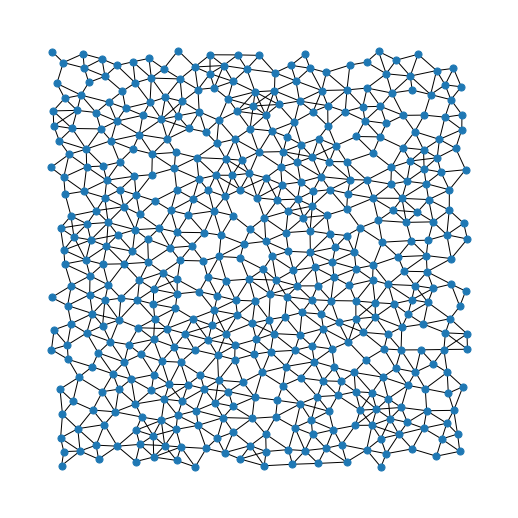

In [108]:
dataset_sample = OneStepDataset(metadata, parsed_data, return_pos=True)
graph, position = dataset_sample[0]

print(f"The first item in the valid set is a graph: {graph}")
print(f"This graph has {graph.num_nodes} nodes and {graph.num_edges} edges.")
print(f"Each node is a particle and each edge is the interaction between two particles.")
print(f"Each node has {graph.num_node_features} categorial feature (Data.x), which represents the type of the node.")
print(f"Each node has a {graph.pos.size(1)}-dim feature vector (Data.pos), which represents the positions and velocities of the particle (node) in several frames.")
print(f"Each edge has a {graph.num_edge_features}-dim feature vector (Data.edge_attr), which represents the relative distance and displacement between particles.")
print(f"The model is expected to predict a {graph.y.size(1)}-dim vector for each node (Data.y), which represents the acceleration of the particle.")

# remove directions of edges, because it is a symmetric directed graph.
nx_graph = pyg.utils.to_networkx(graph).to_undirected()
# remove self loops, because every node has a self loop.
nx_graph.remove_edges_from(nx.selfloop_edges(nx_graph))
plt.figure(figsize=(7, 7))
nx.draw(nx_graph, pos={i: tuple(v) for i, v in enumerate(position)}, node_size=50)
plt.show()